In [1]:
import pandas as pd
import urllib.request
import json
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut, GeocoderUnavailable
import time
import numpy as np  
import folium
import re

In [2]:
# Load data
path = "D:\\OneDrive\\energia_lab\\data\\"
df = pd.read_parquet(path + 'projetos-eficiencia-energetica-empresa-geocoded.parquet')


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7399 entries, 0 to 7398
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   DatGeracaoConjuntoDados       7399 non-null   datetime64[ns]
 1   NomAgente                     7399 non-null   object        
 2   IdeEmpresaProponenteProjeto   7399 non-null   int64         
 3   DscCodProjeto                 7399 non-null   object        
 4   DscTituloProjeto              7399 non-null   object        
 5   DscTipologia                  7399 non-null   object        
 6   VlrCustoTotal                 5229 non-null   float64       
 7   VlrRcbGlobal                  5789 non-null   float64       
 8   VlrEnergiaEconomizadaTotal    6463 non-null   float64       
 9   VlrRetiradaDemandaPontaTotal  6452 non-null   float64       
 10  DscObjetivo                   4186 non-null   object        
 11  DscJustificativa              

In [4]:
df[df['Address'].notnull()][['Address', 'NomAgente', 'Latitude', 'Longitude']].head(10)

,Address,NomAgente,Latitude,Longitude
20,"Copel Distribuição S.A., Rua Vicente Machado, ...",COPEL DISTRIBUICAO S.A.,-25.386962,-51.474271
21,"Copel Distribuição S.A., Rua Vicente Machado, ...",COPEL DISTRIBUICAO S.A.,-25.386962,-51.474271
38,"Companhia Paulista de Força e Luz, Avenida Set...",COMPANHIA PAULISTA DE FORÇA E LUZ,-20.535621,-49.324210
41,"Companhia Paulista de Força e Luz, Avenida Set...",COMPANHIA PAULISTA DE FORÇA E LUZ,-20.535621,-49.324210
43,"Copel Distribuição S.A., Rua Vicente Machado, ...",COPEL DISTRIBUICAO S.A.,-25.386962,-51.474271
44,"Copel Distribuição S.A., Rua Vicente Machado, ...",COPEL DISTRIBUICAO S.A.,-25.386962,-51.474271
45,"Copel Distribuição S.A., Rua Vicente Machado, ...",COPEL DISTRIBUICAO S.A.,-25.386962,-51.474271
46,"Copel Distribuição S.A., Rua Vicente Machado, ...",COPEL DISTRIBUICAO S.A.,-25.386962,-51.474271
47,"Copel Distribuição S.A., Rua Vicente Machado, ...",COPEL DISTRIBUICAO S.A.,-25.386962,-51.474271
48,"Copel Distribuição S.A., Rua Vicente Machado, ...",COPEL DISTRIBUICAO S.A.,-25.386962,-51.474271


In [5]:
count = df[df['Address'].notnull()][['Address', 'NomAgente', 'Latitude', 'Longitude']].shape[0]
print(count)

2448


In [6]:
df[df['Address'].notnull()][['Address', 'NomAgente', 'Latitude', 'Longitude']].head(10)

,Address,NomAgente,Latitude,Longitude
20,"Copel Distribuição S.A., Rua Vicente Machado, ...",COPEL DISTRIBUICAO S.A.,-25.386962,-51.474271
21,"Copel Distribuição S.A., Rua Vicente Machado, ...",COPEL DISTRIBUICAO S.A.,-25.386962,-51.474271
38,"Companhia Paulista de Força e Luz, Avenida Set...",COMPANHIA PAULISTA DE FORÇA E LUZ,-20.535621,-49.324210
41,"Companhia Paulista de Força e Luz, Avenida Set...",COMPANHIA PAULISTA DE FORÇA E LUZ,-20.535621,-49.324210
43,"Copel Distribuição S.A., Rua Vicente Machado, ...",COPEL DISTRIBUICAO S.A.,-25.386962,-51.474271
44,"Copel Distribuição S.A., Rua Vicente Machado, ...",COPEL DISTRIBUICAO S.A.,-25.386962,-51.474271
45,"Copel Distribuição S.A., Rua Vicente Machado, ...",COPEL DISTRIBUICAO S.A.,-25.386962,-51.474271
46,"Copel Distribuição S.A., Rua Vicente Machado, ...",COPEL DISTRIBUICAO S.A.,-25.386962,-51.474271
47,"Copel Distribuição S.A., Rua Vicente Machado, ...",COPEL DISTRIBUICAO S.A.,-25.386962,-51.474271
48,"Copel Distribuição S.A., Rua Vicente Machado, ...",COPEL DISTRIBUICAO S.A.,-25.386962,-51.474271


In [7]:
df['NomAgente'].isnull().sum()

0

In [8]:
df_not_null = df[df['Address'].notnull()][['Address', 'NomAgente', 'Latitude', 'Longitude']]
df_not_null = df_not_null.drop_duplicates()

In [9]:
# Passo 1: Identificar linhas com valores faltantes
mask = df[['Address', 'Latitude', 'Longitude']].isna().any(axis=1)

# Passo 2: Criar dicionário para mapeamento a partir de df_not_null
df_not_null_dict = df_not_null.set_index('NomAgente')[['Address', 'Latitude', 'Longitude']].to_dict('index')

# Função para preencher os valores faltantes
def fill_missing_values(row):
    if pd.isna(row['Address']) or pd.isna(row['Latitude']) or pd.isna(row['Longitude']):
        agent = row['NomAgente']
        if agent in df_not_null_dict:
            row['Address'], row['Latitude'], row['Longitude'] = df_not_null_dict[agent]['Address'], df_not_null_dict[agent]['Latitude'], df_not_null_dict[agent]['Longitude']
    return row

# Aplicar a função para preencher valores faltantes
df.loc[mask] = df.loc[mask].apply(fill_missing_values, axis=1)

# Passo 3: Verificação dos resultados
print(df[['Address', 'Latitude', 'Longitude']].isna().sum())


Address      4951
Latitude     4951
Longitude    4951
dtype: int64


In [10]:
# Set 'NomAgente' as the index
df.set_index('NomAgente', inplace=True)

In [11]:
# Exclude datetime columns and specific numeric columns
numeric_columns = df.select_dtypes(include=[np.number]).columns
numeric_columns = numeric_columns.drop(['IdeEmpresaProponenteProjeto', 'Latitude', 'Longitude'])

# Generate descriptive statistics for the numeric columns
desc_stats = df[numeric_columns].describe()


In [12]:
# Round the values in desc_stats to 2 decimal places
desc_stats_rounded = desc_stats.round(2)

# Set the float_format option in pandas
pd.options.display.float_format = '{:.2f}'.format

# Display the DataFrame
desc_stats_rounded

,VlrCustoTotal,VlrRcbGlobal,VlrEnergiaEconomizadaTotal,VlrRetiradaDemandaPontaTotal
count,5229.00,5789.00,6463.00,6452.00
mean,1172315.63,0.75,2450.97,1074.13
std,4384020.99,9.78,16218.47,38096.93
min,0.00,0.00,0.00,-0.67
25%,69746.00,0.35,116.06,21.33
50%,285082.58,0.55,338.17,72.25
75%,855654.90,0.70,1248.44,292.19
max,186249979.64,720.00,661617.46,3050000.00


In [13]:


# Aggregate the scores again by the index, which represents NomAgente
aggregated_scores = df.groupby(df.index).agg(
    VlrEnergiaEconomizadaTotal=('VlrEnergiaEconomizadaTotal', 'sum'),
    VlrRetiradaDemandaPontaTotal=('VlrRetiradaDemandaPontaTotal', 'sum'),
    VlrCustoTotal=('VlrCustoTotal', 'mean'),  # Continue using mean or consider sum if more appropriate
    Score=('Score', 'mean')
).sort_values(by='Score', ascending=False)  # Sort to get the top-ranked agents

# Display the top rows of the aggregated and ranked DataFrame
aggregated_scores.head()


,VlrEnergiaEconomizadaTotal,VlrRetiradaDemandaPontaTotal,VlrCustoTotal,Score
NomAgente,,,,
Celesc Distribuição S/A,17032.79,3894.06,0.00,697561.67
COMPANHIA ENERGETICA DO PIAUÍ,2704.07,1128.46,0.00,383253.00
Rio Grande Energia S/A,8030.90,1542.65,0.00,277951.50
COMPANHIA ENERGETICA DE ALAGOAS,13556.78,4064.73,5303958.18,225893.80
Enel Distribuicao Sao Paulo,217579.91,33046.10,4544203.94,203848.09


In [14]:
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the scaler to the 'Score' column and transform it
df['Score'] = scaler.fit_transform(df[['Score']])

df['Score']

NomAgente
COMPANHIA ENERGÉTICA DO RIO GRANDE DO NORTE COSERN     0.00
COMPANHIA ENERGÉTICA DO RIO GRANDE DO NORTE COSERN     0.00
COMPANHIA ENERGÉTICA DO RIO GRANDE DO NORTE COSERN      NaN
COMPANHIA ENERGÉTICA DO RIO GRANDE DO NORTE COSERN     0.00
COMPANHIA ENERGÉTICA DO RIO GRANDE DO NORTE COSERN      NaN
                                                       ... 
ENERGISA SUL-SUDESTE - DISTRIBUIDORA DE ENERGIA S/A    0.00
ENERGISA SUL-SUDESTE - DISTRIBUIDORA DE ENERGIA S/A    0.00
Energisa Sul-Sudeste - Distribuidora de Energia S.A    0.00
EQUATORIAL PARA DISTRIBUIDORA DE ENERGIA S.A           0.00
Energisa Mato Grosso - Distribuidora de Energia S.A.   0.00
Name: Score, Length: 7399, dtype: float64

In [15]:
df['Score'].min(), df['Score'].max()

(0.0, 1.0)

In [16]:
aggregated_scores.index = aggregated_scores.index.str.capitalize()

In [17]:
aggregated_scores

,VlrEnergiaEconomizadaTotal,VlrRetiradaDemandaPontaTotal,VlrCustoTotal,Score
NomAgente,,,,
Celesc distribuição s/a,17032.79,3894.06,0.00,697561.67
Companhia energetica do piauí,2704.07,1128.46,0.00,383253.00
Rio grande energia s/a,8030.90,1542.65,0.00,277951.50
Companhia energetica de alagoas,13556.78,4064.73,5303958.18,225893.80
Enel distribuicao sao paulo,217579.91,33046.10,4544203.94,203848.09
...,...,...,...,...
S.a de eletrificacao da paraiba,6981.32,2332.94,NaN,NaN
Sulgipe,3208.20,1231.85,NaN,NaN
Uhenpal,157.27,22.62,NaN,NaN


In [18]:

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the scaler to the 'Score' column and transform it
aggregated_scores['Score'] = scaler.fit_transform(aggregated_scores[['Score']])

aggregated_scores['Score']

NomAgente
Celesc distribuição s/a                 1.00
Companhia energetica do piauí           0.55
Rio grande energia s/a                  0.40
Companhia energetica de alagoas         0.32
Enel distribuicao sao paulo             0.29
                                        ... 
S.a de eletrificacao da paraiba          NaN
Sulgipe                                  NaN
Uhenpal                                  NaN
Usina hidro eletrica nova palma ltda     NaN
Usina hidro eletrica nova palma ltda.    NaN
Name: Score, Length: 537, dtype: float64

In [19]:
aggregated_scores.info()

<class 'pandas.core.frame.DataFrame'>
Index: 537 entries, Celesc distribuição s/a to Usina hidro eletrica nova palma ltda.
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   VlrEnergiaEconomizadaTotal    537 non-null    float64
 1   VlrRetiradaDemandaPontaTotal  537 non-null    float64
 2   VlrCustoTotal                 288 non-null    float64
 3   Score                         288 non-null    float64
dtypes: float64(4)
memory usage: 37.1+ KB


In [20]:
df = df.reset_index()

In [21]:
df[['VlrCustoTotal', 'VlrRcbGlobal', 'VlrEnergiaEconomizadaTotal', 'VlrRetiradaDemandaPontaTotal']].describe()

,VlrCustoTotal,VlrRcbGlobal,VlrEnergiaEconomizadaTotal,VlrRetiradaDemandaPontaTotal
count,5229.00,5789.00,6463.00,6452.00
mean,1172315.63,0.75,2450.97,1074.13
std,4384020.99,9.78,16218.47,38096.93
min,0.00,0.00,0.00,-0.67
25%,69746.00,0.35,116.06,21.33
50%,285082.58,0.55,338.17,72.25
75%,855654.90,0.70,1248.43,292.19
max,186249979.64,720.00,661617.46,3050000.00


In [22]:
df.head()

,NomAgente,DatGeracaoConjuntoDados,IdeEmpresaProponenteProjeto,DscCodProjeto,DscTituloProjeto,DscTipologia,VlrCustoTotal,VlrRcbGlobal,VlrEnergiaEconomizadaTotal,VlrRetiradaDemandaPontaTotal,DscObjetivo,DscJustificativa,DatInicioProjeto,DatConclusaoProjeto,DscMetodologiaMv,Address,Latitude,Longitude,Score
0,COMPANHIA ENERGÉTICA DO RIO GRANDE DO NORTE CO...,2024-04-01,1,PE-00040-0002/2000,Eficientização das Instalações Elétricas da Re...,Poder Público,360261.64,0.47,495.76,125.37,None, O atraso na execução do projeto é devido ao ...,1999-01-01,2000-12-31,None,None,NaN,NaN,0.00
1,COMPANHIA ENERGÉTICA DO RIO GRANDE DO NORTE CO...,2024-04-01,1,PE-00040-0002/2000,Eficientização das Instalações Elétricas da Re...,Poder Público,360261.64,0.69,366.18,86.17,None, O atraso na execução do projeto é devido ao ...,1999-01-01,2000-12-31,None,None,NaN,NaN,0.00
2,COMPANHIA ENERGÉTICA DO RIO GRANDE DO NORTE CO...,2024-04-01,2,PE-00040-0003/1999,Diagnóstico Energético - Sacoplast e Antártica/RN,Industrial,36628.00,NaN,NaN,NaN,None, Elaboração dos instrumentos legais de cooper...,1998-01-01,1999-12-31,None,None,NaN,NaN,NaN
3,COMPANHIA ENERGÉTICA DO RIO GRANDE DO NORTE CO...,2024-04-01,2,PE-00040-0003/1999,Diagnóstico Energético - Sacoplast e Antártica/RN,Industrial,36628.00,NaN,1037.00,504.00,None, Elaboração dos instrumentos legais de cooper...,1998-01-01,1999-12-31,None,None,NaN,NaN,0.00
4,COMPANHIA ENERGÉTICA DO RIO GRANDE DO NORTE CO...,2024-04-01,3,PE-00040-0004/1999,Projeto de Eficientização em Instalações Indus...,Industrial,21250.00,NaN,NaN,NaN,None, Elaboração dos instrumentos legais de cooper...,1998-01-01,1999-12-31,None,None,NaN,NaN,NaN


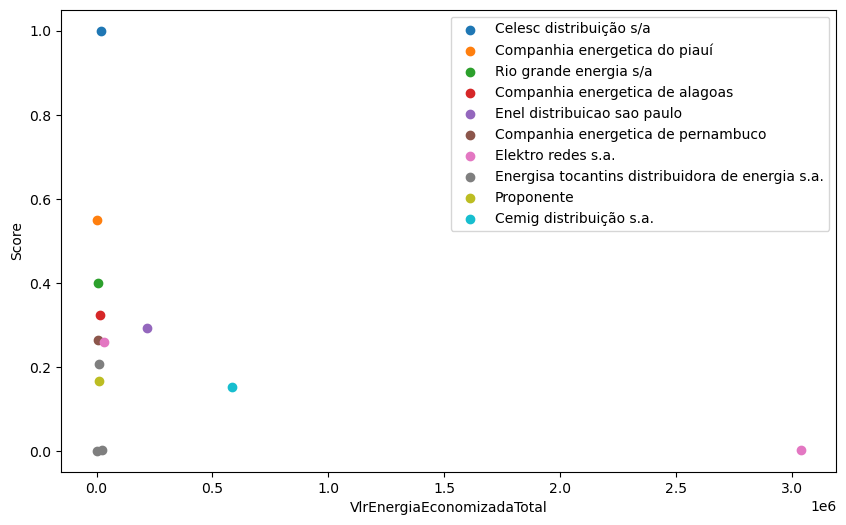

In [23]:
import matplotlib.pyplot as plt

# Sort by 'Score' and select the top 10 'NomAgente'
top_agents = aggregated_scores.sort_values(by='Score', ascending=False).head(10).index

plt.figure(figsize=(10, 6))
for agent in top_agents:
    agent_data = aggregated_scores.loc[agent]
    plt.scatter(agent_data['VlrEnergiaEconomizadaTotal'], agent_data['Score'], label=agent)

plt.xlabel('VlrEnergiaEconomizadaTotal')
plt.ylabel('Score')
plt.legend()
plt.show()

In [24]:

# Define the color scale function
def color_scale(score):
    if score > 0.2:
        return 'darkred'
    elif score > 0.1:
        return 'red'
    elif score > 0.05:
        return 'orange'
    elif score > 0.01:
        return 'lightred'
    elif score > 0.005:
        return 'lightblue'
    else:
        return 'blue'

# Filter the dataframe for non-null latitude, longitude, and score
map_df = df.dropna(subset=['Latitude', 'Longitude', 'Score'])

# Aggregate the scores and other values by NomAgente
aggregated_map_df = map_df.groupby('NomAgente').agg({
    'Score': 'mean',
    'Latitude': 'first',
    'Longitude': 'first',
    'VlrCustoTotal': 'sum',
    'VlrEnergiaEconomizadaTotal': 'sum',
    'VlrRetiradaDemandaPontaTotal': 'sum'
}).reset_index()

# Create a map centered around Brazil
brazil_map = folium.Map(location=[-10.3333333, -53.2], zoom_start=4)

# Add markers to the map with the color scale
for _, row in aggregated_map_df.iterrows():
    popup_text = (f"Agente: {row['NomAgente']}<br>"
                  f"Score Médio: {row['Score']:.4f}<br>"
                  f"Custo Total: {row['VlrCustoTotal']:.2f}<br>"
                  f"Energia Economizada: {row['VlrEnergiaEconomizadaTotal']:.2f}<br>"
                  f"Redução Demanda Ponta: {row['VlrRetiradaDemandaPontaTotal']:.2f}")
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=folium.Popup(popup_text, max_width=250),
        icon=folium.Icon(color=color_scale(row['Score']))
    ).add_to(brazil_map)

# Add a legend to the map
legend_html = '''
<div style="position: fixed; bottom: 50px; left: 50px; width: 180px; height: 160px; 
background-color: white; border:2px solid grey; z-index:9999; font-size:14px; padding: 5px;">
&emsp;<b>Score Legend</b><br>
&emsp;<i class="fa fa-circle" style="color:darkred;"></i>&nbsp;> 0.2<br>
&emsp;<i class="fa fa-circle" style="color:red;"></i>&nbsp;> 0.1<br>
&emsp;<i class="fa fa-circle" style="color:orange;"></i>&nbsp;> 0.05<br>
&emsp;<i class="fa fa-circle" style="color:lightred;"></i>&nbsp;> 0.01<br>
&emsp;<i class="fa fa-circle" style="color:lightblue;"></i>&nbsp;> 0.005<br>
&emsp;<i class="fa fa-circle" style="color:blue;"></i>&nbsp;&le; 0.005
</div>
'''
brazil_map.get_root().html.add_child(folium.Element(legend_html))

# Save the map to an HTML file
map_html_path = path+'brazil_energy_efficiency_map_with_legend.html'
brazil_map.save(map_html_path)


In [25]:
brazil_map

In [26]:
aggregated_scores = aggregated_scores.sort_values('Score', ascending=False)
aggregated_scores.reset_index(inplace=True)

In [27]:
aggregated_scores

,NomAgente,VlrEnergiaEconomizadaTotal,VlrRetiradaDemandaPontaTotal,VlrCustoTotal,Score
0,Celesc distribuição s/a,17032.79,3894.06,0.00,1.00
1,Companhia energetica do piauí,2704.07,1128.46,0.00,0.55
2,Rio grande energia s/a,8030.90,1542.65,0.00,0.40
3,Companhia energetica de alagoas,13556.78,4064.73,5303958.18,0.32
4,Enel distribuicao sao paulo,217579.91,33046.10,4544203.94,0.29
...,...,...,...,...,...
532,S.a de eletrificacao da paraiba,6981.32,2332.94,NaN,NaN
533,Sulgipe,3208.20,1231.85,NaN,NaN
534,Uhenpal,157.27,22.62,NaN,NaN
535,Usina hidro eletrica nova palma ltda,130.01,43.09,NaN,NaN


In [28]:
aggregated_scores.to_parquet(path+'aggregated_scores.parquet')

In [29]:
df = df.sort_values('NomAgente', ascending=True)
df.head(3)

,NomAgente,DatGeracaoConjuntoDados,IdeEmpresaProponenteProjeto,DscCodProjeto,DscTituloProjeto,DscTipologia,VlrCustoTotal,VlrRcbGlobal,VlrEnergiaEconomizadaTotal,VlrRetiradaDemandaPontaTotal,DscObjetivo,DscJustificativa,DatInicioProjeto,DatConclusaoProjeto,DscMetodologiaMv,Address,Latitude,Longitude,Score
6224,03.467.321/0001-99,2024-04-01,9168,PE-00405-0115/2020,Eficientização da Procuradoria Geral de Justiç...,Poder Público,753267.05,0.52,396.42,62.66,Reduzir o consumo de energia elétrica e demand...,None,2020-07-01,2022-12-31,Medição realizada pelo medidor de energia elét...,None,NaN,NaN,0.00
3449,03.467.321/0001-99,2024-04-01,5112,PE-00405-0105/2020,Projeto Iluminação Pública - Município de Alt...,Iluminação Pública,788433.35,0.20,503.44,114.95,Reduzir o consumo de energia no município de A...,A seleção do município para a participação no ...,2020-07-01,2021-12-31,Foi escolhida a opção A de acordo com o IPMVP ...,None,NaN,NaN,0.00
3450,03.467.321/0001-99,2024-04-01,5113,PE-00405-0106/2020,Projeto Iluminação Pública - Município de Nobres,Iluminação Pública,771308.82,0.15,640.40,146.21,Reduzir o consumo de energia no município de N...,A seleção do município para a participação no ...,2020-07-01,2021-12-31,Foi escolhida a opção A de acordo com o IPMVP ...,None,NaN,NaN,0.00


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7399 entries, 6224 to 4641
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   NomAgente                     7399 non-null   object        
 1   DatGeracaoConjuntoDados       7399 non-null   datetime64[ns]
 2   IdeEmpresaProponenteProjeto   7399 non-null   int64         
 3   DscCodProjeto                 7399 non-null   object        
 4   DscTituloProjeto              7399 non-null   object        
 5   DscTipologia                  7399 non-null   object        
 6   VlrCustoTotal                 5229 non-null   float64       
 7   VlrRcbGlobal                  5789 non-null   float64       
 8   VlrEnergiaEconomizadaTotal    6463 non-null   float64       
 9   VlrRetiradaDemandaPontaTotal  6452 non-null   float64       
 10  DscObjetivo                   4186 non-null   object        
 11  DscJustificativa              40

In [31]:
df['Address'].value_counts(dropna=False)

Address
None                                                                                                                                                                                                                                                                                       4951
Copel Distribuição S.A., Rua Vicente Machado, Guarapuava, Região Geográfica Imediata de Guarapuava, Região Geográfica Intermediária de Guarapuava, Paraná, Região Sul, 85010-050, Brasil                                                                                                    693
Companhia Paulista de Força e Luz, Avenida Sete de Setembro, Vila Pavani, Nova Granada, Região Imediata de São José do Rio Preto, Região Metropolitana de São José do Rio Preto, Região Geográfica Intermediária de São José do Rio Preto, São Paulo, Região Sudeste, 15440-000, Brasil     359
Companhia de Eletricidade do Estado da Bahia, Avenida Doutor Guilherme Dias, Ginásio Industrial, Brumado, Região Geográfica Inte

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7399 entries, 6224 to 4641
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   NomAgente                     7399 non-null   object        
 1   DatGeracaoConjuntoDados       7399 non-null   datetime64[ns]
 2   IdeEmpresaProponenteProjeto   7399 non-null   int64         
 3   DscCodProjeto                 7399 non-null   object        
 4   DscTituloProjeto              7399 non-null   object        
 5   DscTipologia                  7399 non-null   object        
 6   VlrCustoTotal                 5229 non-null   float64       
 7   VlrRcbGlobal                  5789 non-null   float64       
 8   VlrEnergiaEconomizadaTotal    6463 non-null   float64       
 9   VlrRetiradaDemandaPontaTotal  6452 non-null   float64       
 10  DscObjetivo                   4186 non-null   object        
 11  DscJustificativa              40

In [33]:
def extract_uf_final(address):
    """
    Extracts the UF (state abbreviation) from an address string by finding the state name immediately
    before the last occurrence of ", Região".

    Args:
    address (str): The full address string.

    Returns:
    str: The extracted UF (state abbreviation) or an empty string if not found.
    """
    if pd.isnull(address):
        return None
    else:
        # Adjusting regex to potentially match multi-word state names
        match = re.search(r', ([\w\s]+), Região(?!.*Região)', address)
        if match:
            return match.group(1).strip()
        else:
            return None

# Applying the extraction function to the 'Address' column in the dataframe
df['UF'] = df['Address'].apply(extract_uf_final)

# Checking the extracted UF values and how many times each UF appears
df['UF'].value_counts(dropna=False)


UF
None                   5182
Paraná                  693
São Paulo               409
Bahia                   294
Rio Grande do Norte     163
Santa Catarina          153
Espírito Santo          138
Pernambuco              125
Rio Grande do Sul        98
Ceará                    63
Pará                     17
Alagoas                  12
Minas Gerais             11
Maranhão                 10
Sergipe                   8
Paraíba                   8
Roraima                   7
Piauí                     5
Goiás                     3
Name: count, dtype: int64

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7399 entries, 6224 to 4641
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   NomAgente                     7399 non-null   object        
 1   DatGeracaoConjuntoDados       7399 non-null   datetime64[ns]
 2   IdeEmpresaProponenteProjeto   7399 non-null   int64         
 3   DscCodProjeto                 7399 non-null   object        
 4   DscTituloProjeto              7399 non-null   object        
 5   DscTipologia                  7399 non-null   object        
 6   VlrCustoTotal                 5229 non-null   float64       
 7   VlrRcbGlobal                  5789 non-null   float64       
 8   VlrEnergiaEconomizadaTotal    6463 non-null   float64       
 9   VlrRetiradaDemandaPontaTotal  6452 non-null   float64       
 10  DscObjetivo                   4186 non-null   object        
 11  DscJustificativa              40

In [35]:
# Performing the aggregation
grouped_df = df.groupby(['NomAgente', 'DscTipologia', 'DatInicioProjeto', 'DatConclusaoProjeto', 'UF']).agg({
    'VlrCustoTotal': 'sum',
    'VlrRcbGlobal': 'sum',
    'VlrEnergiaEconomizadaTotal': 'sum',
    'VlrRetiradaDemandaPontaTotal': 'sum',
    'Score': 'sum'
}).reset_index()


In [36]:
grouped_df.head()

,NomAgente,DscTipologia,DatInicioProjeto,DatConclusaoProjeto,UF,VlrCustoTotal,VlrRcbGlobal,VlrEnergiaEconomizadaTotal,VlrRetiradaDemandaPontaTotal,Score
0,AES ELETROPAULO,Baixa Renda,2013-01-07,2016-12-16,São Paulo,0.00,0.67,63110.28,13747.58,0.00
1,AES ELETROPAULO,Poder Público,2014-07-04,2015-08-24,São Paulo,0.00,0.81,756.71,212.55,0.00
2,AES ELETROPAULO,Residencial,2012-07-05,2016-07-31,São Paulo,0.00,0.74,13157.18,2794.33,0.00
3,AES ELETROPAULO,Residencial,2013-01-03,2016-04-05,São Paulo,0.00,0.25,62853.72,13306.77,0.00
4,AES SUL,Baixa Renda,2013-02-20,2014-11-30,Rio Grande do Sul,0.00,0.04,670.35,259.72,0.00


In [37]:
# Sort grouped_df by 'Score'
sorted_df = grouped_df.sort_values('Score', ascending=False)

sorted_df.head()

,NomAgente,DscTipologia,DatInicioProjeto,DatConclusaoProjeto,UF,VlrCustoTotal,VlrRcbGlobal,VlrEnergiaEconomizadaTotal,VlrRetiradaDemandaPontaTotal,Score
592,Companhia Paulista de Força e Luz,Baixa Renda,2019-08-12,2023-08-10,São Paulo,0.00,0.33,16011.61,8124.48,0.26
979,Copel Distribuição S.A,Residencial,2019-12-17,2023-07-28,Paraná,0.00,0.56,17407.07,4704.76,0.24
502,Celesc Distribuição S/A,Residencial,2019-07-03,2021-08-13,Santa Catarina,0.00,0.72,8587.94,1584.97,0.11
822,Companhia de Eletricidade do Estado da Bahia,Industrial,2019-09-16,2021-03-16,Bahia,0.00,0.14,7172.76,841.31,0.09
450,Celesc Distribuição S.A.,Baixa Renda,2019-03-13,2023-12-13,Santa Catarina,0.00,0.61,4989.70,2293.39,0.08


In [38]:
grouped_df.to_csv(path+'grouped_df.csv', index=False)

In [39]:
# Convert 'DatInicioProjeto' and 'DatConclusaoProjeto' to datetime
grouped_df['DatInicioProjeto'] = pd.to_datetime(grouped_df['DatInicioProjeto'])
grouped_df['DatConclusaoProjeto'] = pd.to_datetime(grouped_df['DatConclusaoProjeto'])

# Calculate project duration in days
grouped_df['ProjectDurationDays'] = (grouped_df['DatConclusaoProjeto'] - grouped_df['DatInicioProjeto']).dt.days

# Compute the average project duration
average_project_duration = grouped_df['ProjectDurationDays'].mean()

average_project_duration


751.1552142279709

In [40]:

# Convert the average project duration to years
average_project_duration_years = average_project_duration / 365.25

average_project_duration_years

2.0565508945324322

In [41]:
# Group by 'UF' and aggregate to find the top companies by Score
top_companies_by_score_uf = grouped_df.groupby('UF').apply(
    lambda x: x.nlargest(1, 'Score')[['NomAgente', 'Score']]
).reset_index()

top_companies_by_score_uf

C:\Users\surze\AppData\Local\Temp\ipykernel_2628\3872612663.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_companies_by_score_uf = grouped_df.groupby('UF').apply(


,UF,level_1,NomAgente,Score
0,Alagoas,1134,Equatorial Alagoas,0.00
1,Bahia,822,Companhia de Eletricidade do Estado da Bahia,0.09
2,Ceará,1079,Enel Distribuicao Ceara,0.00
3,Espírito Santo,1162,Espírito Santo Distribuição de Energia S/A.,0.00
4,Goiás,46,CELG-D,0.00
5,Maranhão,1044,EQUATORIAL ENERGIA MARANHÃO,0.00
6,Minas Gerais,1125,Energisa Minas Gerais,0.00
7,Paraná,979,Copel Distribuição S.A,0.24
8,Paraíba,1122,Energisa Borborema,0.00
9,Pará,65,CENTRAIS ELETRICAS DO PARA,0.02


In [42]:
# Grouping by 'DscTipologia' and calculating aggregated metrics
tipologia_summary = grouped_df.groupby('DscTipologia').agg({
    'Score': ['mean', 'max'],
    'VlrCustoTotal': 'mean',
    'VlrEnergiaEconomizadaTotal': 'mean',
    'VlrRetiradaDemandaPontaTotal': 'mean',
    }).reset_index()

In [48]:
# Grouping by 'DscTipologia' and calculating aggregated metrics
tipologia_summary = grouped_df.groupby('DscTipologia').agg({
    'Score': ['mean', 'max'],
    'VlrCustoTotal': 'mean',
    'VlrEnergiaEconomizadaTotal': 'mean',
    'VlrRetiradaDemandaPontaTotal': 'mean',
}).reset_index()

# Flatten the MultiIndex in columns
tipologia_summary.columns = [' '.join(col).strip() for col in tipologia_summary.columns.values]


In [49]:
tipologia_summary

,DscTipologia,Score mean,Score max,VlrCustoTotal mean,VlrEnergiaEconomizadaTotal mean,VlrRetiradaDemandaPontaTotal mean
0,Aquecimento Solar,0.00,0.00,275082.35,151.06,284.24
1,Baixa Renda,0.00,0.26,2087974.56,6671.49,2267.71
2,Comércio e Serviços,0.00,0.02,1221371.08,1625.17,141.39
3,Educacional,0.00,0.00,1143407.24,3576.02,174.00
4,Gestão Energética Municipal,0.00,0.00,599640.53,0.00,0.00
5,Iluminação Pública,0.00,0.02,3010016.91,2187.48,504.88
6,Industrial,0.00,0.09,1200896.87,2984.00,347.95
7,Marketing,0.00,0.00,389396.92,45.00,0.00
8,Pelo Lado da Oferta/Fator de Carga,0.00,0.01,2774830.56,0.00,1367.72
9,Pelo Lado da Oferta/Perdas,0.00,0.00,11416915.50,40104.80,17122.60


In [50]:
# Sort tipologia_summary by 'max' Score
sorted_tipologia_summary = tipologia_summary.sort_values(('Score max'), ascending=False)

sorted_tipologia_summary

,DscTipologia,Score mean,Score max,VlrCustoTotal mean,VlrEnergiaEconomizadaTotal mean,VlrRetiradaDemandaPontaTotal mean
1,Baixa Renda,0.00,0.26,2087974.56,6671.49,2267.71
13,Residencial,0.00,0.24,1134650.96,7945.89,2301.35
6,Industrial,0.00,0.09,1200896.87,2984.00,347.95
10,Poder Público,0.00,0.03,920925.95,1294.54,276.03
5,Iluminação Pública,0.00,0.02,3010016.91,2187.48,504.88
2,Comércio e Serviços,0.00,0.02,1221371.08,1625.17,141.39
8,Pelo Lado da Oferta/Fator de Carga,0.00,0.01,2774830.56,0.00,1367.72
15,Serviços Públicos,0.00,0.00,610102.02,933.73,252.36
3,Educacional,0.00,0.00,1143407.24,3576.02,174.00
9,Pelo Lado da Oferta/Perdas,0.00,0.00,11416915.50,40104.80,17122.60


In [51]:

sorted_tipologia_summary.to_csv(path+'sorted_tipologia_summary.csv', index=False)

In [52]:
df.to_csv(path+'projetos-eficiencia-energetica-empresa-geocoded.csv')